In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle as cPickle
import pandas as pd
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
import sklearn.metrics
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import concatenate
from tensorflow.keras import Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from keras import models

In [3]:
data_student = "/content/drive/nuinvtnu 2021/Github_Data_Codes/CTM_Hien/Data/Data for Student/"
data_teacher = "/content/drive/nuinvtnu 2021/Github_Data_Codes/CTM_Hien/Data/Data for Student/"
path = "/content/drive/nuinvtnu 2021/Github_Data_Codes/CTM_Hien/Data/Data for Student/"

In [4]:
def twoTupleDic3():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']

    AA_dict = {}
    numm = 1
    for i in AA_list_sort:
        for j in AA_list_sort:
          for jj in AA_list_sort:
             AA_dict[i+j+jj] = numm
             numm += 1
    return AA_dict
def twoTupleDic2():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']

    AA_dict = {}
    numm = 1
    for i in AA_list_sort:
        for j in AA_list_sort:
          AA_dict[i+j] = numm
          numm += 1
    return AA_dict

def twoTupleDic1():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']

    AA_dict = {}
    numm = 1
    for i in AA_list_sort:
        AA_dict[i] = numm
        numm += 1
    return AA_dict
def ProSentence(pro, K):
	sentence = ""
	length = len(pro)
	for i in range(length - K + 1):
		sentence += pro[i: i + K] + " "
    #delete extra space
	sentence = sentence[0 : len(sentence) - 1]
	return sentence
k =1#1-gram
word_index1 = twoTupleDic1()
vocab_size = len(word_index1)
num_folds = 5
TIME_STEPS = 33
INPUT_SIZE = 300

**Load data

In [7]:
# Load Traindata
import pandas as pd
file_train_student = "train_data_31_Arathailiana_1_1.csv"
df_train_student =pd.read_csv(data_student+file_train_student, delimiter= ',')

texts_train_student =[] #PTMsequend kmer
for i in df_train_student['Sequence']:
  temp = ProSentence(i,k)
  texts_train_student.append(temp)
df_train_student['k_mer'] =texts_train_student
train_sequences_student = []
for each in texts_train_student:
    each_index_list = []
    each = each.split(' ')
    for i in each:
        each_index_list.append(word_index1[i])
    train_sequences_student.append(each_index_list)
# Tokenizer train data input Word2vec
data_token_student = []
for i in df_train_student['k_mer']:
   data_token_student.append(i.split())

MAX_SEQUENCE_LENGTH_student = len(data_token_student[1])
Xtrain_student = pad_sequences(train_sequences_student, maxlen=MAX_SEQUENCE_LENGTH_student)
ytrain_student = np.array(df_train_student['Label'])
ytrain_student = np.array(ytrain_student)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
ytrain_student = lb.fit_transform(ytrain_student)
ytrain_student = to_categorical(ytrain_student)
ytrain_student.shape


(3064, 2)

In [8]:
# load test data for student
file_test_student ="test_data_31_Arathailiana_1_1.csv"
df_test_student =pd.read_csv(data_student+file_test_student,delimiter= ',')
text_test_student =[] #PTMsequend kmer
for i in df_test_student['Sequence']:
  temp = ProSentence(i,k)
  text_test_student.append(temp)
df_test_student['k_mer'] =text_test_student

test_sequences_student = []
for each in text_test_student:
    each_index_list = []
    each = each.split(' ')
    for i in each:
        each_index_list.append(word_index1[i])
    test_sequences_student.append(each_index_list)

Xtest_student = pad_sequences(test_sequences_student, maxlen=MAX_SEQUENCE_LENGTH_student)
ytest_student = np.array(df_test_student['Label'])
# perform one-hot encoding on the labels
ytest_student = np.array(ytest_student)
lb = LabelBinarizer()
ytest_student= lb.fit_transform(ytest_student)
ytest_student = to_categorical(ytest_student)
ytest_student.shape

(1022, 2)

**Define model**

In [9]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
teacher = keras.Sequential(
    [
        layers.Embedding(vocab_size+1, 300, input_length=MAX_SEQUENCE_LENGTH_teacher,trainable=True),
        #layers.dropout(0.2),
        layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2),
        layers.Dropout(0.2),
        #layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dropout(0.2),
        layers.Dense(2),
        layers.Activation('softmax'),

    ],
    name="teacher",
)

teacher.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        "categorical_accuracy",
        "AUC",

    ],
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
)
student = keras.Sequential(
    [
        layers.Embedding(vocab_size+1, 300, input_length=MAX_SEQUENCE_LENGTH_teacher,trainable=True),
        #layers.dropout(0.2),
        layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        layers.Dropout(0.2),
        #layers.LSTM(300, dropout=0.2, recurrent_dropout=0.2),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dropout(0.2),
        layers.Dense(2),
        layers.Activation('softmax'),
    ],
    name="student",
)
student_scratch = keras.models.clone_model(student)

In [10]:
checkpoint = EarlyStopping(monitor='val_loss',
            min_delta=0,
            patience=3,
            verbose=1, mode='auto')
result_test =data_student +"Result_KD.txt"


Knowledge Distillation base on LSTM

In [15]:
# Train teacher and save model
teacher.fit(Xtrain_student,ytrain_student, batch_size=16, epochs=50)#,validation_data =(Xtest_teacher, ytest_teacher), shuffle = True,callbacks=[checkpoint],verbose=1)
teacher.save(path +'model_teacher.h5')
ypred = teacher.predict(Xtest_student)
ypred =np.argmax(ypred,axis =1)

ytest_true =  np.argmax(ytest_student,axis =1)

result22 = confusion_matrix(ytest_true,ypred)
print(result22)

Epoch 1/50
192/192 [==============================] - 36s 185ms/step - loss: 0.5774 - categorical_accuracy: 0.6883 - auc: 0.7658
Epoch 2/50
192/192 [==============================] - 34s 177ms/step - loss: 0.4817 - categorical_accuracy: 0.7826 - auc: 0.8515
Epoch 3/50
192/192 [==============================] - 33s 171ms/step - loss: 0.4613 - categorical_accuracy: 0.7918 - auc: 0.8623
Epoch 4/50
192/192 [==============================] - 33s 174ms/step - loss: 0.4505 - categorical_accuracy: 0.8006 - auc: 0.8698
Epoch 5/50
192/192 [==============================] - 33s 170ms/step - loss: 0.4376 - categorical_accuracy: 0.8016 - auc: 0.8753
Epoch 6/50
192/192 [==============================] - 33s 170ms/step - loss: 0.4298 - categorical_accuracy: 0.8074 - auc: 0.8836
Epoch 7/50
192/192 [==============================] - 33s 169ms/step - loss: 0.3949 - categorical_accuracy: 0.8277 - auc: 0.9012
Epoch 8/50
192/192 [==============================] - 32s 169ms/step - loss: 0.3854 - categorical

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 2s 40ms/step
[[419  92]
 [ 61 450]]


In [16]:
# Independent test Knowlege distillation model
#Load model teacher for train student
teacher_model = models.load_model(path+'model_teacher.h5')
distiller = Distiller(student=student, teacher=teacher_model)
distiller.compile(
      student_loss_fn= keras.losses.CategoricalCrossentropy(from_logits=True),
      #student_loss_fn= keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer=keras.optimizers.AdamW(learning_rate = 0.0001),
      metrics=[
              "categorical_accuracy",
              "AUC",
              ], # , f1
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=0.1,
      temperature=10
      )

history_KD = distiller.fit(Xtrain_student,ytrain_student, batch_size=16,epochs=50)#, validation_data =(Xtest_student, ytest_student), callbacks=[checkpoint],verbose=1)
result2 = distiller.evaluate(Xtest_student, ytest_student)#, validation_data=(X_test,Y_test), shuffle = True,callbacks=[checkpoint],verbose=1)
f = open(result_test, 'a+', encoding='UTF-8')
f.write("\n Independent model KD_BiLSTM  \n ")
s = str(result2)
f.write(s)
f.close()

ypred = student.predict(Xtest_student)
ypred =np.argmax(ypred,axis =1)

ytest_true =  np.argmax(ytest_student,axis =1)

result22 = confusion_matrix(ytest_true,ypred)
print(result22)
f = open(result_test, 'a+', encoding='UTF-8')
f.write("\n confusion_matrix KD_BIlstm: Student \n ")
s = str(result22)
f.write(s)
f.close()
# save model student
student.save(path +"KD_LSTM.h5")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


192/192 [==============================] - 21s 82ms/step - categorical_accuracy: 0.8734 - auc: 0.9452 - student_loss: 0.2992 - distillation_loss: 0.0067
Epoch 2/50
192/192 [==============================] - 16s 82ms/step - categorical_accuracy: 0.8779 - auc: 0.9486 - student_loss: 0.2924 - distillation_loss: 0.0063
Epoch 3/50
192/192 [==============================] - 17s 86ms/step - categorical_accuracy: 0.8763 - auc: 0.9483 - student_loss: 0.2946 - distillation_loss: 0.0059
Epoch 4/50
192/192 [==============================] - 16s 82ms/step - categorical_accuracy: 0.8750 - auc: 0.9485 - student_loss: 0.2919 - distillation_loss: 0.0059
Epoch 5/50
192/192 [==============================] - 16s 83ms/step - categorical_accuracy: 0.8734 - auc: 0.9457 - student_loss: 0.2971 - distillation_loss: 0.0054
Epoch 6/50
192/192 [==============================] - 17s 86ms/step - categorical_accuracy: 0.8773 - auc: 0.9476 - student_loss: 0.2922 - distillation_loss: 0.0055
Epoch 7/50
192/192 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[[421  90]
 [ 60 451]]


Models predict

In [17]:
from keras import models
model_KD = models.load_model(path +"KD_LSTM.h5")
y_prob_KD = model_KD.predict(Xtest_student)
pd.DataFrame(y_prob_KD[:,1], columns=['KD_pred']).to_csv(path +'KD_prediction.csv')

32/32 [==============================] - 1s 11ms/step


Train data with model: Teacher, Student
Using Student data

In [24]:
# Model Student test independent base on Student dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Flatten, Dense
# Define your student model
model_student = Sequential()
model_student.add(Embedding(vocab_size + 1, 300, input_length=MAX_SEQUENCE_LENGTH_student, trainable=True))
model_student.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_student.add(Dropout(0.2))
model_student.add(Flatten())
model_student.add(Dense(128, activation='relu'))
model_student.add(Dropout(0.2))
model_student.add(Dense(2, activation='softmax'))

metrics=[
          "accuracy",
          "AUC",
          ]
model_student.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=metrics)

# Train your model
history_model_student = model_student.fit(Xtrain_student, ytrain_student, batch_size=16, epochs=50, validation_data=(Xtest_student, ytest_student),callbacks=[checkpoint],verbose=1)

# Evaluate your model
result2 = model_student.evaluate(Xtest_student, ytest_student)

# Save evaluation results to a file
with open(result_test, 'a+', encoding='UTF-8') as f:
    f.write("\n Model Student: Test independent \n ")
    f.write(str(result2))

# Make predictions
ypred = model_student.predict(Xtest_student)
ypred = np.argmax(ypred, axis=1)

# Calculate confusion matrix
result22 = confusion_matrix(np.argmax(ytest_student, axis=1), ypred)
print(result22)
# Save confusion matrix to a file
with open(result_test, 'a+', encoding='UTF-8') as f:
    f.write("\n model Student: Confusion matrix \n ")
    f.write(str(result22))
model_student.save(path +"model_student.h5")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


192/192 [==============================] - 10s 38ms/step - loss: 0.6877 - accuracy: 0.5770 - auc: 0.6110 - val_loss: 0.6652 - val_accuracy: 0.6487 - val_auc: 0.7077
Epoch 2/50
192/192 [==============================] - 7s 37ms/step - loss: 0.5491 - accuracy: 0.7216 - auc: 0.7948 - val_loss: 0.4964 - val_accuracy: 0.7613 - val_auc: 0.8386
Epoch 3/50
192/192 [==============================] - 7s 36ms/step - loss: 0.4771 - accuracy: 0.7735 - auc: 0.8496 - val_loss: 0.4568 - val_accuracy: 0.7945 - val_auc: 0.8610
Epoch 4/50
192/192 [==============================] - 6s 33ms/step - loss: 0.4604 - accuracy: 0.7941 - auc: 0.8649 - val_loss: 0.4421 - val_accuracy: 0.8043 - val_auc: 0.8679
Epoch 5/50
192/192 [==============================] - 7s 34ms/step - loss: 0.4378 - accuracy: 0.7973 - auc: 0.8740 - val_loss: 0.4346 - val_accuracy: 0.8043 - val_auc: 0.8749
Epoch 6/50
192/192 [==============================] - 6s 33ms/step - loss: 0.4323 - accuracy: 0.8061 - auc: 0.8779 - val_loss: 0.4274 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Model Teacher test independent base on Student dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Flatten, Dense

# Define your teacher model
model_teacher = Sequential()
model_teacher.add(Embedding(vocab_size + 1, 300, input_length=MAX_SEQUENCE_LENGTH_student, trainable=True))
model_teacher.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model_teacher.add(Dropout(0.2))
model_teacher.add(Flatten())
model_teacher.add(Dense(128, activation='relu'))
model_teacher.add(Dropout(0.2))
model_teacher.add(Dense(2, activation='softmax'))

metrics=[
          "accuracy",
          "AUC",
          ]
model_teacher.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=metrics)

# Train your model
history_model_teacher = model_teacher.fit(Xtrain_student, ytrain_student, batch_size=16, epochs=50, validation_data=(Xtest_student, ytest_student),callbacks=[checkpoint],verbose=1)

# Evaluate your model
result2 = model_teacher.evaluate(Xtest_student, ytest_student)

# Save evaluation results to a file
with open(result_test, 'a+', encoding='UTF-8') as f:
    f.write("\n Model teacher: Independent test \n ")
    f.write(str(result2))

# Make predictions
ypred = model_teacher.predict(Xtest_student)
ypred = np.argmax(ypred, axis=1)

# Calculate confusion matrix
result22 = confusion_matrix(np.argmax(ytest_student, axis=1), ypred)
print(result22)
# Save confusion matrix to a file
with open(result_test, 'a+', encoding='UTF-8') as f:
    f.write("\n Model teacher: Confusion matric \n ")
    f.write(str(result22))
model_teacher.save(path +"model_teacher.h5")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


192/192 [==============================] - 19s 86ms/step - loss: 0.6300 - accuracy: 0.6508 - auc: 0.7058 - val_loss: 0.5258 - val_accuracy: 0.7583 - val_auc: 0.8401
Epoch 2/50
192/192 [==============================] - 16s 84ms/step - loss: 0.4974 - accuracy: 0.7706 - auc: 0.8372 - val_loss: 0.4602 - val_accuracy: 0.7955 - val_auc: 0.8669
Epoch 3/50
192/192 [==============================] - 17s 91ms/step - loss: 0.4490 - accuracy: 0.7944 - auc: 0.8685 - val_loss: 0.4518 - val_accuracy: 0.8072 - val_auc: 0.8705
Epoch 4/50
192/192 [==============================] - 16s 83ms/step - loss: 0.4327 - accuracy: 0.8012 - auc: 0.8771 - val_loss: 0.4397 - val_accuracy: 0.7945 - val_auc: 0.8784
Epoch 5/50
192/192 [==============================] - 17s 90ms/step - loss: 0.4372 - accuracy: 0.8003 - auc: 0.8770 - val_loss: 0.4238 - val_accuracy: 0.8151 - val_auc: 0.8858
Epoch 6/50
192/192 [==============================] - 16s 84ms/step - loss: 0.4062 - accuracy: 0.8127 - auc: 0.8946 - val_loss: 0.4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#cross-validation teacher

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix


kf = KFold(n_splits=num_folds, shuffle=True)

X_student = Xtrain_student
Y_student = ytrain_student

for train_index_student, test_index_student in kf.split(X_student,Y_student):
    X_train_student, X_test_student =X_student[train_index_student], X_student[test_index_student]
    Y_train_student, Y_test_student = Y_student[train_index_student], Y_student[test_index_student]



    model_teacher = Sequential()
    model_teacher.add(Embedding(vocab_size + 1, 300, input_length=MAX_SEQUENCE_LENGTH_student, trainable=True))
    model_teacher.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
    model_teacher.add(Dropout(0.2))
    model_teacher.add(Flatten())
    model_teacher.add(Dense(128, activation='relu'))
    model_teacher.add(Dropout(0.2))
    model_teacher.add(Dense(2, activation='softmax'))
    model_teacher.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy','AUC'])
    # Train your model
    history_model_teacher = model_teacher.fit(X_train_student, Y_train_student, batch_size=16, epochs=50, validation_data=(X_test_student, Y_test_student),callbacks=[checkpoint],verbose=1)
    # Evaluate your model
    result2 = model_teacher.evaluate(X_test_student, Y_test_student)
    # Save evaluation results to a file
    with open(result_test, 'a+', encoding='UTF-8') as f:
        f.write("\n Cross validation Model teacher \n ")
        f.write(str(result2))
    # Make predictions
    ypred = model_teacher.predict(X_test_student)
    ypred = np.argmax(ypred, axis=1)
    # Calculate confusion matrix
    result22 = confusion_matrix(np.argmax(Y_test_student, axis=1), ypred)
    print(result22)
    # Save confusion matrix to a file
    with open(result_test, 'a+', encoding='UTF-8') as f:
        f.write("\n model teacher \n ")
        f.write(str(result22))

In [ ]:
# kiểm thử chéo model sinh viên
from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

X_student = Xtrain_student
Y_student = ytrain_student

for train_index_student, test_index_student in kf.split(X_student,Y_student):
    X_train_student, X_test_student =X_student[train_index_student], X_student[test_index_student]
    Y_train_student, Y_test_student = Y_student[train_index_student], Y_student[test_index_student]
    model_student = Sequential()
    model_student.add(Embedding(vocab_size + 1, 300, input_length=MAX_SEQUENCE_LENGTH_student, trainable=True))
    model_student.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model_student.add(Dropout(0.2))
    model_student.add(Flatten())
    model_student.add(Dense(128, activation='relu'))
    model_student.add(Dropout(0.2))
    model_student.add(Dense(2, activation='softmax'))
    model_student.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.0001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy','AUC'])

    # Train your model
    history_model_student = model_student.fit(X_train_student, Y_train_student, batch_size=16, epochs=50, validation_data=(X_test_student, Y_test_student),callbacks=[checkpoint],verbose=1)

    # Evaluate your model
    result2 = model_student.evaluate(X_test_student, Y_test_student)

    # Save evaluation results to a file
    with open(result_test, 'a+', encoding='UTF-8') as f:
        f.write("\n Cross validation Model Student \n ")
        f.write(str(result2))

    # Make predictions
    ypred = model_student.predict(X_test_student)
    ypred = np.argmax(ypred, axis=1)

    # Calculate confusion matrix
    result22 = confusion_matrix(np.argmax(Y_test_student, axis=1), ypred)
    print(result22)
    # Save confusion matrix to a file
    with open(result_test, 'a+', encoding='UTF-8') as f:
        f.write("\n model Student \n ")
        f.write(str(result22))


Models predict and draw ROC

In [18]:
from keras import models
model_teacher = models.load_model(path +"model_teacher.h5")


#y_prob_teacher = np.array(list(map(predict_prob, model_teacher.predict(Xtest_student))))
y_prob_teacher = model_teacher.predict(Xtest_student)
pd.DataFrame(y_prob_teacher[:,1], columns=['predictions']).to_csv(path +'teacher_prediction.csv')

32/32 [==============================] - 3s 93ms/step


In [19]:
from keras import models
model_student = models.load_model(path +"model_student.h5")


#y_prob_st = np.array(list(map(predict_prob, model_student.predict(Xtest_student))))
y_prob_st =model_student.predict(Xtest_student)
pd.DataFrame(y_prob_st[:,1], columns=['student_pred']).to_csv(path +'student_prediction.csv')

32/32 [==============================] - 1s 11ms/step


In [20]:
from keras import models
model_KD = models.load_model(path +"KD_LSTM.h5")
y_prob_KD = model_KD.predict(Xtest_student)
pd.DataFrame(y_prob_KD[:,1], columns=['KD_pred']).to_csv(path +'KD_prediction.csv')

32/32 [==============================] - 1s 12ms/step


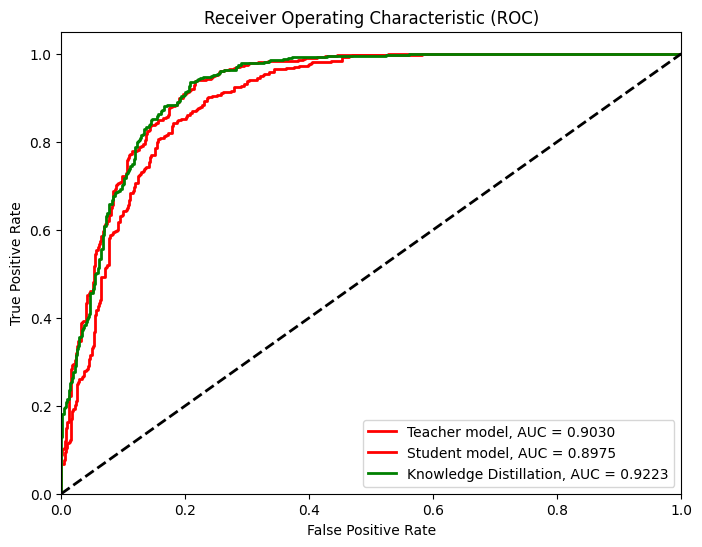

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from keras import models
from sklearn import metrics
# Generate some sample data (replace this with your actual data)
# Assuming y_true and y_pred are your true labels and predicted probabilities respectively


y_true=ytest_student[:,1]

# Calculate ROC curve and AUC for Teacher

#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
fpr_teacher, tpr_teacher, thresholds_teacher  = metrics.roc_curve(y_true, y_prob_teacher[:,1])
roc_auc_teacher = auc(fpr_teacher, tpr_teacher)

# Calculate ROC curve and AUC for Student
fpr_student, tpr_student, thresholds_student = metrics.roc_curve(y_true, y_prob_st[:,1])
roc_auc_student = auc(fpr_student, tpr_student)
# Calculate ROC curve and AUC for Knowlege distillation
fpr_KD, tpr_KD, thresholds_KD = metrics.roc_curve(y_true, y_prob_KD[:,1])
roc_auc_KD = auc(fpr_KD, tpr_KD)
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_teacher, tpr_teacher, color='red', lw=2, label='Teacher model, AUC = {:.4f}'.format(0.903))
plt.plot(fpr_student, tpr_student,  color='red', lw=2, label='Student model, AUC = {:.4f}'.format(roc_auc_student))
plt.plot(fpr_KD, tpr_KD, color='green',lw=2, label='Knowledge Distillation, AUC = {:.4f}'.format(roc_auc_KD))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
distiller.summary()